<a href="https://colab.research.google.com/github/garnieroeliari/sporting_goods_retailer/blob/main/image_processing/notebook/vanillacnn_predict_dina_pytorch_sporting_goods_retailer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sporting goods retailer prediction - Binary Image Classification
##**Load previously saved model and make prediction**

By Dina Garnier-Oeliarisoa

The sporting goods retailer detection model was trained from [here](https://colab.research.google.com/drive/1Zmv5Edsb_TR2TwCn68Dv0w68txzw-0ZZ?usp=sharing) 

##**Import libraries**


In [1]:
# Libraries
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
class SportingClassifier(nn.Module):
    def __init__(self):
        super(SportingClassifier, self).__init__()
        
        
        self.block1 = self.conv_block(c_in=3, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=4, kernel_size=75, stride=1, padding=0)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
    def forward(self, x):
        x = self.block1(x)
        x = self.maxpool(x)
        
        x = self.block2(x)
    
        x = self.block3(x)
        x = self.maxpool(x)
        
        x = self.lastcnn(x)
        
        return x
    
    
    def conv_block(self, c_in, c_out, dropout, **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block        

In [4]:
# LOAD THE ENTIRE MODEL
sporting_model = torch.load('/content/drive/MyDrive/Colab Notebooks/colab_image_processing/output/all_classif_sporting.pt')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/"
print("The data lies here =>", root_dir)

We're using => cuda
The data lies here => /content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/


In [6]:
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler

image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ]),
    "test": transforms.Compose([
        transforms.Resize((300, 300)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],
                             [0.5, 0.5, 0.5])
    ])
}

In [7]:
sporting_dataset = datasets.ImageFolder(root = root_dir + "train",
                                      transform = image_transforms["train"]
                                     )

In [8]:
sporting_dataset.class_to_idx
idx2class = {v: k for k, v in sporting_dataset.class_to_idx.items()}

In [9]:
from PIL import Image
import os
import os.path
import sys
import requests
import matplotlib.pyplot as plt
import numpy as np

def pil_loader(path):    
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def makePrediction(model, url):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = image_transforms["test"]

    test_image = Image.open(requests.get(url, stream=True).raw)
    #test_image= pil_loader(requests.get(url, stream=True).raw)

    plt.imshow(test_image)

    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.unsqueeze(0)       
    test_image_tensor = test_image_tensor.view(3, 300, 300).to(device)
    
    with torch.no_grad():
      model.eval()
      test_image_tensor = test_image_tensor.unsqueeze(0)        
      out = model(test_image_tensor)        
      sm=torch.nn.Softmax(dim=1)
      proba=sm(out)        
      topk, topclass = proba.topk(1, dim=1) 
              
      #*******begin following code if NO GPU*****
      #print (idx2class)
      #print("predicted class : "+str(topclass))
      #print ("probability : "+str(topk))
      #*******end following code if NO GPU*******

      #******begin following code if there is a GPU*******
      numpy_topclass=topclass.detach().cpu().numpy()        
      pred_proba=numpy_topclass[0][0][0][0]
      print("class : "+idx2class[pred_proba])       
      numpy_topk=topk.detach().cpu().numpy()        
      pred_proba=numpy_topk[0][0][0][0]
      print("probability : "+str(pred_proba))
      #*****end following code if there is a GPU***** 
      #print(f"Prediction {i+1} : {idx2class[topclass.cpu().numpy()[0][i]]}, Score: {topk.cpu().numpy()[0][i] * 100}%")

In [10]:
def makePrediction2(model, image):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    transform = image_transforms["test"]

    #test_image = Image.open(image)
    test_image= pil_loader(image)

    plt.imshow(test_image)

    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.unsqueeze(0)       
    test_image_tensor = test_image_tensor.view(3, 300, 300).to(device)
    
    with torch.no_grad():
      model.eval()
      test_image_tensor = test_image_tensor.unsqueeze(0)        
      out = model(test_image_tensor)        
      sm=torch.nn.Softmax(dim=1)
      proba=sm(out)        
      topk, topclass = proba.topk(1, dim=1) 
              
      #*******begin following code if NO GPU*****
      #print (idx2class)
      #print("predicted class : "+str(topclass))
      #print ("probability : "+str(topk))
      #*******end following code if NO GPU*******

      #******begin following code if there is a GPU*******
      numpy_topclass=topclass.detach().cpu().numpy()        
      pred_proba=numpy_topclass[0][0][0][0]
      print("class : "+idx2class[pred_proba])       
      numpy_topk=topk.detach().cpu().numpy()        
      pred_proba=numpy_topk[0][0][0][0]
      print("probability : "+str(pred_proba))
      #*****end following code if there is a GPU***** 
      #print(f"Prediction {i+1} : {idx2class[topclass.cpu().numpy()[0][i]]}, Score: {topk.cpu().numpy()[0][i] * 100}%")

class : decathlon
probability : 0.99160844


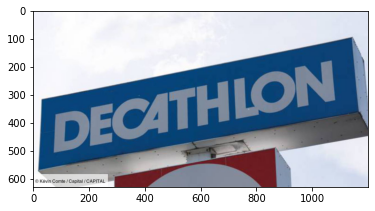

In [11]:
makePrediction(sporting_model, 'https://cap.img.pmdstatic.net/fit/http.3A.2F.2Fprd2-bone-image.2Es3-website-eu-west-1.2Eamazonaws.2Ecom.2Fcap.2F2020.2F06.2F11.2F51eba602-db1b-417d-a32b-118c06b7233c.2Ejpeg/1200x630/background-color/ffffff/quality/70/cr/wqkgS8OpdmluIENvbXRlIC8gQ2FwaXRhbCAvIENBUElUQUw%3D/decathlon-a-lattaque-dun-nouveau-pays-1372451.jpg')

class : gosport
probability : 1.0


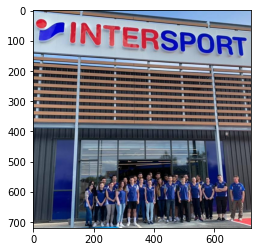

In [12]:
makePrediction(sporting_model,'https://www.pagesjaunes.fr/media/cviv/59537976_N_0001_photo.jpeg')

In [13]:
!ls "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test"

decathlon  gosport  intersport	sport2000


In [14]:
!ls "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/decathlon"

128.jpg  133.jpg


class : gosport
probability : 1.0


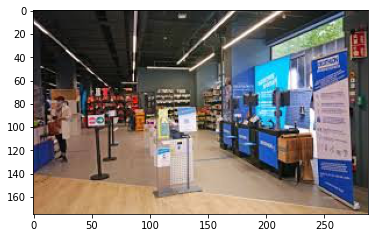

In [15]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/decathlon/128.jpg')

class : sport2000
probability : 0.99999595


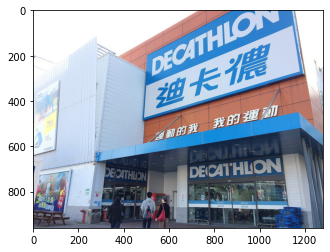

In [16]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/decathlon/133.jpg')

In [17]:
!ls "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/intersport"

66.jpg	72.jpg


class : intersport
probability : 1.0


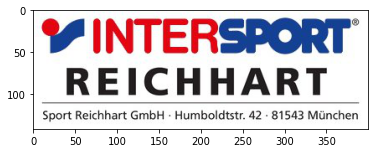

In [18]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/intersport/66.jpg')

class : intersport
probability : 1.0


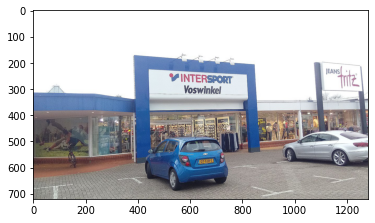

In [19]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/intersport/72.jpg')

In [20]:
!ls "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/gosport"

39.jpg	48.jpg


class : sport2000
probability : 1.0


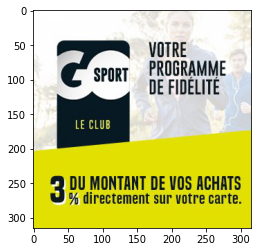

In [21]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/gosport/39.jpg')

class : intersport
probability : 1.0


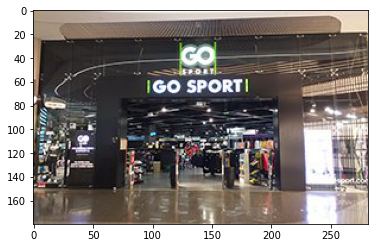

In [22]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/gosport/48.jpg')

In [23]:
!ls "/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/sport2000"

30.jpg	31.jpg


class : sport2000
probability : 1.0


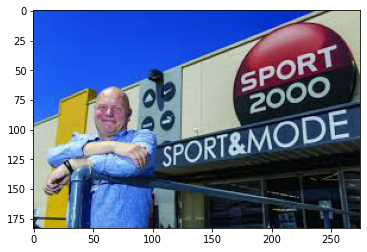

In [24]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/sport2000/30.jpg')

class : decathlon
probability : 1.0


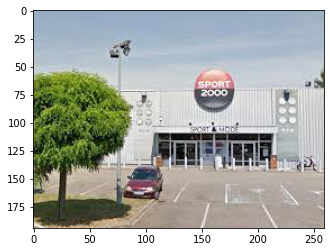

In [25]:
makePrediction2(sporting_model, '/content/drive/MyDrive/data_image_side_project/sporting_goods_retailer/test/sport2000/31.jpg')